In [43]:
import gallery_detection_models.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torch.utils.tensorboard import SummaryWriter
importlib.reload(models)
cuda = torch.device('cuda')


## Parameters

In [54]:
DATASET = "dataset_03"
DATASET_FOLDER = f"/home/lorenzo/datasets/{DATASET}"
MODEL = models.gallery_detector_v3
SAVE_FOLDER = f"/home/lorenzo/models/gallery_detection/procedural_datasets/{DATASET}"
n_epochs = int(64*8)
batch_size = 1024
lrs= [0.002]
try:
    os.mkdir(SAVE_FOLDER)
except:
    pass
save_path = os.path.join(SAVE_FOLDER,MODEL.__name__+"-_r10_lr002_3.torch")
print(save_path)

/home/lorenzo/models/gallery_detection/procedural_datasets/dataset_03/gallery_detector_v3-_r10_lr002_3.torch


## Load dataset

In [45]:
# Define the dataset
class ImageDataset(Dataset):
    def __init__(self, path_to_dataset):
        self.device = torch.device(
            "cuda:0")
        self.load_dataset(path_to_dataset)

    def load_dataset(self, dataset_folder):
        n_datapoints = 0
        envs = os.listdir(dataset_folder)
        envs.sort()
        for env in envs:
            env_folder = os.path.join(dataset_folder, env)
            data_folder = os.path.join(env_folder, "data")
            if os.path.isdir(data_folder):
                n_datapoints += len(os.listdir(data_folder))
            else:
                envs.remove(env)
        self.n_datapoints = n_datapoints
        self.labels = torch.zeros((self.n_datapoints, 360)).float()
        self.images = torch.zeros((self.n_datapoints,1,16,360)).float()
        n = 0
        for env in envs:
            print(env)
            env_folder = os.path.join(dataset_folder, env)
            data_folder = os.path.join(env_folder, "data")
            dtp_names = os.listdir(data_folder)
            dtp_names.sort()
            for dtp_n, dtp_name in enumerate(dtp_names):
                print(f"{dtp_n:04d}",end="\r")
                dtp_path = os.path.join(data_folder, dtp_name)
                dtp = np.load(dtp_path)
                self.labels[n, :] = torch.tensor(dtp["label"])
                self.images[n,0, :,:] = torch.tensor(dtp["image"])
                n+=1

    def __len__(self):
        return self.n_datapoints

    def __getitem__(self, idx):
        image = self.images[idx, ...]
        result = self.labels[idx, ...]
        roll = np.random.randint(0,360)
        image = torch.roll(image,roll,2)
        result = torch.roll(result,roll,0)
        return image.float(), result.float()

dataset = ImageDataset(DATASET_FOLDER)

env_001
env_002
env_003
env_004
env_007
env_008
env_009
env_010
env_011
env_013
env_014
env_016


In [46]:
n = 0

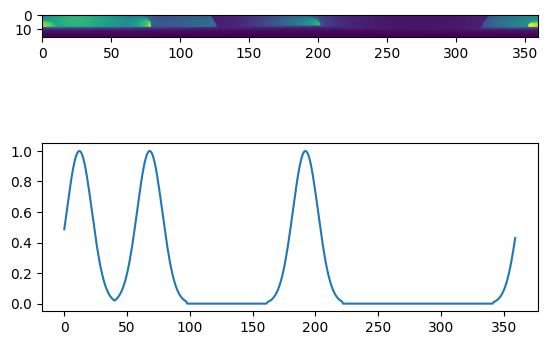

In [47]:
image, result = dataset[n]
n+=1
plt.subplot(2,1,1)
plt.imshow(image[0])
plt.subplot(2,1,2)
plt.plot(result)
plt.show()

In [48]:
train_dataset, test_dataset = random_split(dataset,[0.9,0.1])
torch.cuda.empty_cache()
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=5)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=5)
    

### Explore dataset

In [49]:
n = 0
for i, data in enumerate(train_dataset):
    image, label = data
    if torch.max(label) < 0.5:
        n+=1
print(n)

478


## Train network

In [50]:
def basic_train(network, train_loader, criterion, optimizer, n_epochs,lr,tensorborad_folder="/home/lorenzo/tensor_board"):
    shutil.rmtree(tensorborad_folder) 
    os.mkdir(tensorborad_folder)
    writer = SummaryWriter(log_dir=tensorborad_folder)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        loss_history = []
        print("", end="\r")
        print("Epoch {} out of {}".format(
            epoch + 1, n_epochs), end="")
        for i, data in enumerate(train_loader):
            torch.cuda.empty_cache()
            inputs, labels = data
            inputs = inputs.to(torch.device("cuda"))
            labels = labels.to(torch.device("cuda"))
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            j = i + epoch * train_loader.__len__()
            writer.add_scalar(f"Loss/train/lr_{lr}",loss,j)
        fig = plt.figure(1)
        plt.subplot(211)
        plt.imshow(inputs[0][0].detach().cpu().numpy())
        plt.subplot(212)
        plt.gca().clear()
        plt.plot(outputs[0].detach().cpu().numpy())
        plt.plot(labels[0].detach().cpu().numpy())
        plt.gca().set_xlim(0,360)
        fig.canvas.draw()
        writer.add_figure(f"result/lr{lr}",fig,epoch)

### Train

In [51]:
network = MODEL().to(cuda).float()

In [56]:
network.to(cuda)
for lr in lrs:
    torch.cuda.empty_cache()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        network.parameters(),
        lr=lr,
    )
    loss_hist = basic_train(
        network, train_dataloader, criterion, optimizer, n_epochs, lr
    )

Epoch 512 out of 512

In [57]:
network.to("cpu")
print(save_path)
torch.save(network.state_dict(), save_path)

/home/lorenzo/models/gallery_detection/procedural_datasets/dataset_03/gallery_detector_v3-_r10_lr002_3.torch
